<a href="https://colab.research.google.com/github/MrEplenier/deep-reinforcement-learning/blob/master/Trex_Run_Double_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mode d'emploi**

---

### Pour intéragir avec le jeu du dino

* Mettre à jour Google Chrome à la dernière version
* Télécharger "chromedriver" correspondant à la version de Google Chrome sur : https://chromedriver.chromium.org
* Changer les liens dans le code pour accéder au fichier chromedriver.exe (ne pas mettre le ".exe" dans le nom du chemin)
* Choisir la position ainsi que les dimensions de la fenêtre Google Chrome
* Choisir en conséquence la position ainsi que les dimensions de la capture d'écran (à faire dans le **`get_state()`**)

---

### Commencer un nouvel entraînement

* Dans la section *\"Réseau de neurones de convolution"* :
  * Changer **`continuer = True`** en **`continuer = False`**

---

### Sauvegarder/Charger un réseau de neurones, une mémoire, des scores et continuer un entraînement

* A la fin la section *\"Entraînement"* :
  * Changer les noms des dossiers pour pouvoir sauvegarder le CNN, la mémoire et les scores sur votre ordinateur

* Dans la section *\"Réseau de neurones de convolution"* :
  * Changer **`continuer = False`** en **`continuer = True`**
  * Changer les noms des dossiers pour pouvoir charger les différents éléments que vous avez sauvegardé.

* Les noms de dossiers de sauvegarde et de chargement doivent être les mêmes 



## Modules

In [ ]:
# importation des modules nécessaires
import numpy as np 
from skimage import transform
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from collections import deque
from PIL import ImageGrab
from options import Options, attrs
import random
import time
import mss
import pickle

# Importation du module Keras (réseau de neurones)
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

# Importation du module Selenium (communication avec le navigateur internet)
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

## Création de l'environnement

---

### Actions sur l'environnement
* **`restart()`** : Lance ou relance une partie
* **`do_action()`** : effectue l'action choisie
* **`end()`** : ferme le jeu

---

### Récupération d'informations sur le jeu
* **`get_crashed()`** : True ou False, savoir si il y a "Game Over"
* **`get_score()`** : récupère le score de la partie en cours
* **`get_state()`** : capture l'image du jeu 


In [ ]:
# Ouverture de Google Chrome et du dino
env = webdriver.Chrome(executable_path = "D:/Desktop/Nouveau dossier/chromedriver")

# Position de la fenêtre de Chrome
env.set_window_position(x = -10, y = 0)

# Dimension de la fenêtre de Chrome
env.set_window_size(600, 400)

# Accerder au site où se trouve le jeu du dino
env.get('chrome://dino')

# Nous fixons l'accélération du jeu à 0
env.execute_script("Runner.config.ACCELERATION=0")


# Fonctions qui permettent de récupérer des informations du jeu et de le contrôler

def get_crashed():
    return env.execute_script("return Runner.instance_.crashed")

def restart():
    env.execute_script("Runner.instance_.restart()")
    time.sleep(0.25) # no actions are possible, for 0.25 sec after game starts, skip learning at this time and make the model wait

def do_action(x):
    if x == 1:
        env.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    else:
        env.find_element_by_tag_name("body").send_keys()

def get_score():
    score_array = env.execute_script("return Runner.instance_.distanceMeter.digits")
    score = ''.join(score_array) # The javascript object is of type array with score in the formate[1,0,0] which is 100.
    return int(score)

def end():
    env.close()
  
def get_state():
    # On définit la région de l'écran à capturer
    monitor = {"top": 150, "left": 0, "width": 350, "height": 170}
    # On capture la région définie ci-dessus
    screen = np.array(mss.mss().grab(monitor))
    return screen

## Environnement

---

### Actions

* **`0`** : Ne rien faire
* **`1`** : Faire sauter le dino

In [ ]:
nb_actions = 2
actions_space = [0, 1]
dim_observations = (80, 80)

print('Nombre d\'actions possibles : {}'.format(nb_actions))
print('Dimension des observations : {}'.format(dim_observations))

Nombre d'actions possibles : 2
Dimension des observations : (80, 80)


## Preprocessing des images

---

### Transformations et empilement d'images

* Nous **capturons** des images du jeu que nous **traitons** pour améliorer le temps de calcul du CNN
* L'observation finale est un **empilement de 4 images** (frames) successives de taille (80, 80)
* Cet empilemet permet au CNN de mieux **capter le mouvement** de l'agent (dino)

In [ ]:
# Transformations des images
def preprocess(observation):
    
    # Transformation en noir et blanc
    observation = rgb2gray(observation)
    
    # Normalisation
    observation.astype('float32')
    # Permet d'améliorer la rapidité du modèle
    observation /= 255.0

    # Réduction de la résolution
    observation = observation[::2,::2]

    # Redimensionner les images
    observation = transform.resize(observation, [80, 80])

    return observation


# Empilement des images
# On empile les images par lot de 4, pour que le réseau de neuronnes puisse capter le mouvement du dino
stack_size = 4

# On empile et on mémorise les 4 dernières photos dans une mémoire de taille 4 initialisée ci-dessous
stack_memory = deque([np.zeros(dim_observations) for i in range(stack_size)], maxlen=4)

def stack(stack_memory, observation, new_episode):
    
    # Transformation des images
    observation = preprocess(observation)
  
    # Dans le cas où nous commençons une nouvelle partie 
    if new_episode:
        
        # On vide la mémoire et on la réinitialise
        stack_memory = deque([np.zeros(dim_observations) for i in range(stack_size)], maxlen=4)
    
        # Comme c'est un nouvel épisode, on mémorise 4 fois la même image
        stack_memory.append(observation)
        stack_memory.append(observation)
        stack_memory.append(observation)
        stack_memory.append(observation)

        # On empile les 4 images mémorisées
        stack_frames = np.stack(stack_memory, axis = 2).reshape(1, dim_observations[0], dim_observations[1], 4)
      
    else:
        
        # On mémorise la nouvelle image en supprimant la plus ancienne des 4
        stack_memory.append(observation)

        # On empile les 4 images mémorisées
        stack_frames = np.stack(stack_memory, axis=2).reshape(1, dim_observations[0], dim_observations[1], 4)

    return stack_frames, stack_memory

### Exemple de transformation et d'empilement d'images

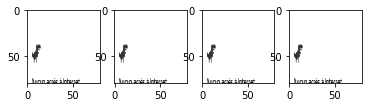

In [ ]:
# Exemple
frame = get_state()
frames, stack_memery = stack(stack_memory, frame, new_episode = True)

for i in range(4):
    plt.subplot(1,4,i+1)
    frame = frames[:,:,:,i].reshape(dim_observations)
    plt.imshow(frame, cmap = "gray")
    
plt.show()

## Test de l'environnement (actions aléatoires)
Cette étape est facultative, elle permet de voir comment se comporte l'environnement.

Reward : -5, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : -5, Done : False
Reward : 1, Done : False
Reward : 1, Done : False
Reward : 1, Done : False
Rew

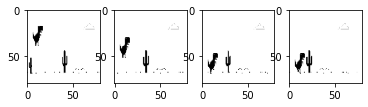

In [ ]:
# Test de l'environnement (actions aléatoires)
restart()
score = 0
reward = 0

# On récupère l'image initiale (l'état initial dans lequel se trouve l'agent)
frames, stack_memery = stack(stack_memory, frame, new_episode = True)


# On joue une partie (la fin est quand le dino heurte un obstacle)
while(True):

    # On prend une action aléatoire
    action = random.sample(actions_space, 1)[0]
    do_action(action)
    
    # On récupère le nouvelle empilement d'images
    frames, stack_memery = stack(stack_memory, get_state(), new_episode = False)
    
    # on récupère le score
    score = get_score()

    # Modélisation de la récompense attribuée à chaque action
    
    if get_crashed():
        # Si on obtient un "Game Over"
        reward = -100
    else:
        if action == 1:
            # Si le dino saute
            reward = -5
        else:
            # Si le dino décide de ne rien faire
            reward = 1
            
    # Savoir si il y a un "Game Over"
    done = get_crashed()
    
    print('Reward : {}, Done : {}'.format(reward, done))
    
    # Si il y a un "Game Over", on arrête la partie
    if get_crashed():
        score = get_score()
        print('Game Over / Score : {}'.format(score))
        break

# On affiche (à titre d'exemple) les 4 images successives
for i in range(4):
    plt.subplot(1,4,i+1)
    frame = frames[:,:,:,i].reshape(dim_observations)
    plt.imshow(frame, cmap = "gray")
plt.show()

## Paramètres
* **`epsilon`** : taux initial d'actions aléatoires
* **`epsilon_min`** : taux final d'actions aléatoires
* **`epsilon_decay`** : coefficient multiplicatif de descente appliqué au pourcentage d’action aléatoires
* **`learning_rate`** : vitesse d'aprentissage
* **`discount_rate`** : facteur gamma de l’équation de Bellman pour donner moins d’importance aux récompenses des actions futures
* **`memory`** : mémoire utilisée pour stocker toutes les expériences accumulées
* **`batch_size`** : nombre de fois où nous fittons le réseau de neurones entre chaque partie

In [ ]:
epsilon = 0.05
epsilon_min = 0.001
epsilon_decay = 0.9995
learning_rate = 0.001
discount_rate = 0.95
memory = deque(maxlen = 30000)
batch_size = 48

## Réseau de neuronnes de convolution

Dans ce modèle, nous utilisons l'architecture "Double DQN", censée être plus performante que l'architecture "DQN" et qui permet en théorique l'overfitting.  

Le "Double DQN" comporte deux réseaux de neurones identiques.

Deux possibilités :
* **Continuer** un entrînement déjà commencé auparavant
* **Commencer** un nouvel entraînement (on initialise les CNN)

In [ ]:
'''
Ancien modèle, abandonné car trop peu de résultats satisfaisants obtenus

# DQN

continuer = False

if continuer:
    model = load_model("D:/Desktop/Nouveau dossier/DinoAI.h5")
else:
    model = Sequential()

    cnn_input_shape = (dim_observations[0], dim_observations[1], 4)

    # 3 couches de convolutions
    model.add(Conv2D(32, kernel_size = 8, strides = 4, activation = 'relu', input_shape = cnn_input_shape, padding = 'valid'))
    model.add(Conv2D(64, kernel_size = 4, strides = 2, activation = 'relu', padding = 'valid'))
    model.add(Conv2D(64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'valid'))

    model.add(Flatten())

    # 2 couches de neuronnes
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(nb_actions, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = Adam(lr = learning_rate))

    model.summary()
'''

'\nAncien modèle, abandonné car trop peu de résultats satisfaisants obtenus\n\n# DQN\n\ncontinuer = False\n\nif continuer:\n    model = load_model("D:/Desktop/Nouveau dossier/DinoAI.h5")\nelse:\n    model = Sequential()\n\n    cnn_input_shape = (dim_observations[0], dim_observations[1], 4)\n\n    # 3 couches de convolutions\n    model.add(Conv2D(32, kernel_size = 8, strides = 4, activation = \'relu\', input_shape = cnn_input_shape, padding = \'valid\'))\n    model.add(Conv2D(64, kernel_size = 4, strides = 2, activation = \'relu\', padding = \'valid\'))\n    model.add(Conv2D(64, kernel_size = 3, strides = 1, activation = \'relu\', padding = \'valid\'))\n\n    model.add(Flatten())\n\n    # 2 couches de neuronnes\n    model.add(Dense(512, activation = \'relu\'))\n    model.add(Dense(nb_actions, activation = \'linear\'))\n    model.compile(loss = \'mse\', optimizer = Adam(lr = learning_rate))\n\n    model.summary()\n'

In [ ]:
# Double DQN

# On définit une fonction qui construit et initialise un réseau de neurones de convolution

def build_model():
    model = Sequential()

    cnn_input_shape = (dim_observations[0], dim_observations[1], 4)
    
    # 3 couches de convolutions
    model.add(Conv2D(32, kernel_size = 8, strides = 4, activation = 'relu', input_shape = cnn_input_shape, padding = 'valid'))
    model.add(Conv2D(64, kernel_size = 4, strides = 2, activation = 'relu', padding = 'valid'))
    model.add(Conv2D(64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'valid'))

    model.add(Flatten())

    # 2 couches de neuronnes
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(nb_actions, activation = 'linear'))
    
    model.compile(loss = 'mse', optimizer = Adam(lr = learning_rate))
    model.summary()
    
    return model

# Si l'utilisateur souhaite continuer un entraînement qu'il avait lancé auparavant
continuer = True

if continuer:
    model = load_model("D:/Desktop/Nouveau dossier/DinoAI.h5")
    target_model = load_model("D:/Desktop/Nouveau dossier/DinoAI.h5")
    print("Les réseaux de neurones sont chargés")
    memory = pickle.load(open("D:/Desktop/Nouveau dossier/memory.data", "rb"))
    print("La mémoire est chargée")
    scores = pickle.load(open("D:/Desktop/Nouveau dossier/scores.data", "rb"))
    print("Les scores sont chargés")
else:
    scores = []
    model = build_model()
    target_model = build_model()

Les réseaux de neurones sont chargés
La mémoire est chargée
Les scores sont chargés


## Entraînement
#### Exploration vs Exploitation
* ***Exploration*** : actions aléatoires
* ***Exploitation*** : actions prédites par le modèle

Le paramètre **`epislon`** correspond au niveau d'exploration.

Au cours de l'entraînement du modèle, le niveau d'exploration diminue petit à petit, ce qui augmente le niveau d'exploitation.

Episode : 0/1000000000, Score : 43, Exploration : 5%
Episode : 1/1000000000, Score : 40, Exploration : 5%
Episode : 2/1000000000, Score : 40, Exploration : 5%
Episode : 3/1000000000, Score : 40, Exploration : 5%
Episode : 4/1000000000, Score : 40, Exploration : 5%
Episode : 5/1000000000, Score : 40, Exploration : 5%
Episode : 6/1000000000, Score : 40, Exploration : 5%
Episode : 7/1000000000, Score : 40, Exploration : 5%
Episode : 8/1000000000, Score : 40, Exploration : 5%
Episode : 9/1000000000, Score : 40, Exploration : 5%
Episode : 10/1000000000, Score : 40, Exploration : 5%
Episode : 11/1000000000, Score : 40, Exploration : 5%
Episode : 12/1000000000, Score : 40, Exploration : 5%
Episode : 13/1000000000, Score : 50, Exploration : 5%
Episode : 14/1000000000, Score : 41, Exploration : 5%
Episode : 15/1000000000, Score : 40, Exploration : 5%
Episode : 16/1000000000, Score : 40, Exploration : 5%
Episode : 17/1000000000, Score : 40, Exploration : 5%
Episode : 18/1000000000, Score : 40, E

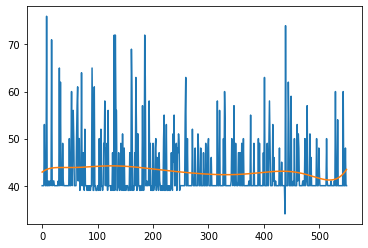

Episode : 50/1000000000, Score : 40, Exploration : 5%
Episode : 51/1000000000, Score : 40, Exploration : 5%
Episode : 52/1000000000, Score : 40, Exploration : 5%
Episode : 53/1000000000, Score : 40, Exploration : 5%
Episode : 54/1000000000, Score : 40, Exploration : 5%
Episode : 55/1000000000, Score : 40, Exploration : 5%
Episode : 56/1000000000, Score : 40, Exploration : 5%
Episode : 57/1000000000, Score : 59, Exploration : 5%
Episode : 58/1000000000, Score : 40, Exploration : 5%
Episode : 59/1000000000, Score : 40, Exploration : 5%
Episode : 60/1000000000, Score : 40, Exploration : 5%
Episode : 61/1000000000, Score : 40, Exploration : 5%
Episode : 62/1000000000, Score : 40, Exploration : 5%
Episode : 63/1000000000, Score : 40, Exploration : 5%
Episode : 64/1000000000, Score : 40, Exploration : 5%
Episode : 65/1000000000, Score : 40, Exploration : 5%
Episode : 66/1000000000, Score : 50, Exploration : 5%
Episode : 67/1000000000, Score : 47, Exploration : 5%
Episode : 68/1000000000, Sco

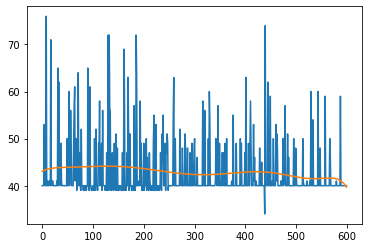

Episode : 100/1000000000, Score : 40, Exploration : 5%
Episode : 101/1000000000, Score : 40, Exploration : 5%
Episode : 102/1000000000, Score : 40, Exploration : 5%
Episode : 103/1000000000, Score : 40, Exploration : 5%
Episode : 104/1000000000, Score : 40, Exploration : 5%
Episode : 105/1000000000, Score : 40, Exploration : 5%
Episode : 106/1000000000, Score : 40, Exploration : 5%
Episode : 107/1000000000, Score : 40, Exploration : 5%
Episode : 108/1000000000, Score : 40, Exploration : 5%
Episode : 109/1000000000, Score : 40, Exploration : 5%
Episode : 110/1000000000, Score : 40, Exploration : 5%
Episode : 111/1000000000, Score : 40, Exploration : 5%
Episode : 112/1000000000, Score : 40, Exploration : 5%
Episode : 113/1000000000, Score : 40, Exploration : 5%
Episode : 114/1000000000, Score : 40, Exploration : 5%
Episode : 115/1000000000, Score : 48, Exploration : 5%
Episode : 116/1000000000, Score : 41, Exploration : 5%
Episode : 117/1000000000, Score : 48, Exploration : 5%
Episode : 

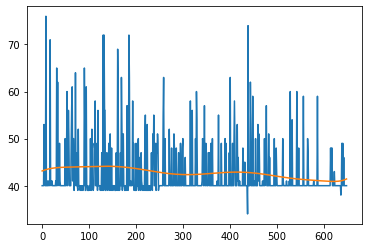

Episode : 150/1000000000, Score : 40, Exploration : 5%
Episode : 151/1000000000, Score : 56, Exploration : 5%
Episode : 152/1000000000, Score : 40, Exploration : 5%
Episode : 153/1000000000, Score : 40, Exploration : 5%
Episode : 154/1000000000, Score : 40, Exploration : 5%
Episode : 155/1000000000, Score : 40, Exploration : 5%
Episode : 156/1000000000, Score : 40, Exploration : 5%
Episode : 157/1000000000, Score : 40, Exploration : 5%
Episode : 158/1000000000, Score : 40, Exploration : 5%
Episode : 159/1000000000, Score : 40, Exploration : 5%
Episode : 160/1000000000, Score : 40, Exploration : 5%
Episode : 161/1000000000, Score : 40, Exploration : 5%
Episode : 162/1000000000, Score : 40, Exploration : 5%
Episode : 163/1000000000, Score : 40, Exploration : 5%
Episode : 164/1000000000, Score : 40, Exploration : 5%
Episode : 165/1000000000, Score : 43, Exploration : 5%
Episode : 166/1000000000, Score : 40, Exploration : 5%
Episode : 167/1000000000, Score : 40, Exploration : 5%
Episode : 

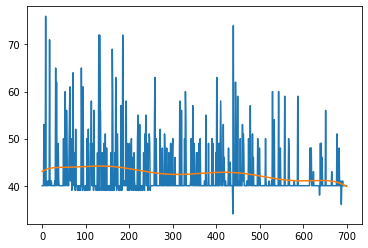

Episode : 200/1000000000, Score : 40, Exploration : 5%
Episode : 201/1000000000, Score : 40, Exploration : 5%
Episode : 202/1000000000, Score : 41, Exploration : 5%
Episode : 203/1000000000, Score : 40, Exploration : 5%
Episode : 204/1000000000, Score : 40, Exploration : 5%
Episode : 205/1000000000, Score : 40, Exploration : 5%
Episode : 206/1000000000, Score : 50, Exploration : 5%
Episode : 207/1000000000, Score : 40, Exploration : 5%
Episode : 208/1000000000, Score : 41, Exploration : 5%
Episode : 209/1000000000, Score : 40, Exploration : 5%
Episode : 210/1000000000, Score : 40, Exploration : 5%
Episode : 211/1000000000, Score : 40, Exploration : 4%
Episode : 212/1000000000, Score : 40, Exploration : 4%
Episode : 213/1000000000, Score : 40, Exploration : 4%
Episode : 214/1000000000, Score : 45, Exploration : 4%
Episode : 215/1000000000, Score : 40, Exploration : 4%
Episode : 216/1000000000, Score : 40, Exploration : 4%
Episode : 217/1000000000, Score : 40, Exploration : 4%
Episode : 

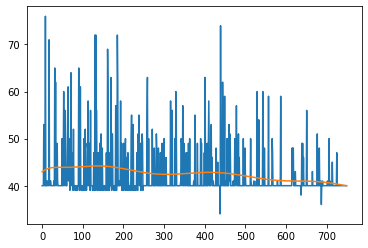

Episode : 250/1000000000, Score : 40, Exploration : 4%
Episode : 251/1000000000, Score : 40, Exploration : 4%
Episode : 252/1000000000, Score : 40, Exploration : 4%
Episode : 253/1000000000, Score : 40, Exploration : 4%
Episode : 254/1000000000, Score : 40, Exploration : 4%
Episode : 255/1000000000, Score : 41, Exploration : 4%
Episode : 256/1000000000, Score : 40, Exploration : 4%
Episode : 257/1000000000, Score : 40, Exploration : 4%
Episode : 258/1000000000, Score : 40, Exploration : 4%
Episode : 259/1000000000, Score : 40, Exploration : 4%
Episode : 260/1000000000, Score : 42, Exploration : 4%
Episode : 261/1000000000, Score : 41, Exploration : 4%
Episode : 262/1000000000, Score : 40, Exploration : 4%
Episode : 263/1000000000, Score : 40, Exploration : 4%
Episode : 264/1000000000, Score : 40, Exploration : 4%
Episode : 265/1000000000, Score : 50, Exploration : 4%
Episode : 266/1000000000, Score : 41, Exploration : 4%
Episode : 267/1000000000, Score : 40, Exploration : 4%
Episode : 

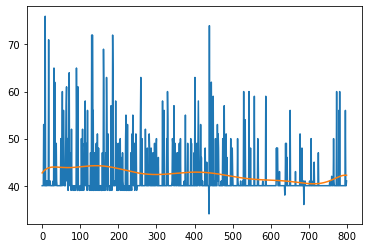

Episode : 300/1000000000, Score : 40, Exploration : 4%
Episode : 301/1000000000, Score : 40, Exploration : 4%
Episode : 302/1000000000, Score : 40, Exploration : 4%
Episode : 303/1000000000, Score : 56, Exploration : 4%
Episode : 304/1000000000, Score : 40, Exploration : 4%
Episode : 305/1000000000, Score : 40, Exploration : 4%
Episode : 306/1000000000, Score : 40, Exploration : 4%
Episode : 307/1000000000, Score : 59, Exploration : 4%
Episode : 308/1000000000, Score : 40, Exploration : 4%
Episode : 309/1000000000, Score : 40, Exploration : 4%
Episode : 310/1000000000, Score : 40, Exploration : 4%
Episode : 311/1000000000, Score : 40, Exploration : 4%
Episode : 312/1000000000, Score : 40, Exploration : 4%
Episode : 313/1000000000, Score : 40, Exploration : 4%
Episode : 314/1000000000, Score : 40, Exploration : 4%
Episode : 315/1000000000, Score : 40, Exploration : 4%
Episode : 316/1000000000, Score : 40, Exploration : 4%
Episode : 317/1000000000, Score : 40, Exploration : 4%
Episode : 

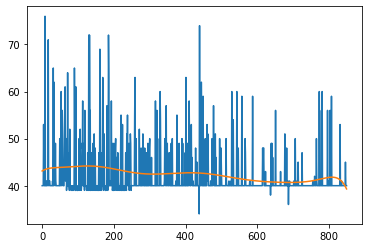

Episode : 350/1000000000, Score : 40, Exploration : 4%
Episode : 351/1000000000, Score : 40, Exploration : 4%
Episode : 352/1000000000, Score : 40, Exploration : 4%
Episode : 353/1000000000, Score : 47, Exploration : 4%
Episode : 354/1000000000, Score : 40, Exploration : 4%
Episode : 355/1000000000, Score : 47, Exploration : 4%
Episode : 356/1000000000, Score : 40, Exploration : 4%
Episode : 357/1000000000, Score : 40, Exploration : 4%
Episode : 358/1000000000, Score : 40, Exploration : 4%
Episode : 359/1000000000, Score : 40, Exploration : 4%
Episode : 360/1000000000, Score : 40, Exploration : 4%
Episode : 361/1000000000, Score : 40, Exploration : 4%
Episode : 362/1000000000, Score : 65, Exploration : 4%
Episode : 363/1000000000, Score : 40, Exploration : 4%
Episode : 364/1000000000, Score : 41, Exploration : 4%
Episode : 365/1000000000, Score : 40, Exploration : 4%
Episode : 366/1000000000, Score : 40, Exploration : 4%
Episode : 367/1000000000, Score : 40, Exploration : 4%
Episode : 

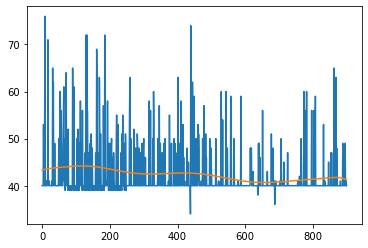

Episode : 400/1000000000, Score : 40, Exploration : 4%
Episode : 401/1000000000, Score : 40, Exploration : 4%
Episode : 402/1000000000, Score : 40, Exploration : 4%
Episode : 403/1000000000, Score : 40, Exploration : 4%
Episode : 404/1000000000, Score : 40, Exploration : 4%
Episode : 405/1000000000, Score : 29, Exploration : 4%
Episode : 406/1000000000, Score : 40, Exploration : 4%
Episode : 407/1000000000, Score : 40, Exploration : 4%
Episode : 408/1000000000, Score : 41, Exploration : 4%
Episode : 409/1000000000, Score : 40, Exploration : 4%
Episode : 410/1000000000, Score : 40, Exploration : 4%
Episode : 411/1000000000, Score : 40, Exploration : 4%
Episode : 412/1000000000, Score : 40, Exploration : 4%
Episode : 413/1000000000, Score : 40, Exploration : 4%
Episode : 414/1000000000, Score : 40, Exploration : 4%
Episode : 415/1000000000, Score : 40, Exploration : 4%
Episode : 416/1000000000, Score : 40, Exploration : 4%
Episode : 417/1000000000, Score : 40, Exploration : 4%
Episode : 

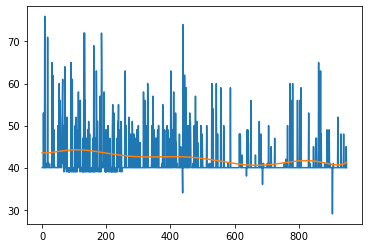

Episode : 450/1000000000, Score : 40, Exploration : 4%
Episode : 451/1000000000, Score : 47, Exploration : 4%
Episode : 452/1000000000, Score : 40, Exploration : 4%
Episode : 453/1000000000, Score : 40, Exploration : 4%
Episode : 454/1000000000, Score : 43, Exploration : 4%
Episode : 455/1000000000, Score : 40, Exploration : 4%
Episode : 456/1000000000, Score : 46, Exploration : 4%
Episode : 457/1000000000, Score : 40, Exploration : 4%
Episode : 458/1000000000, Score : 40, Exploration : 4%
Episode : 459/1000000000, Score : 40, Exploration : 4%
Episode : 460/1000000000, Score : 40, Exploration : 4%
Episode : 461/1000000000, Score : 40, Exploration : 4%
Episode : 462/1000000000, Score : 40, Exploration : 4%
Episode : 463/1000000000, Score : 43, Exploration : 4%
Episode : 464/1000000000, Score : 40, Exploration : 4%
Episode : 465/1000000000, Score : 40, Exploration : 4%
Episode : 466/1000000000, Score : 40, Exploration : 4%
Episode : 467/1000000000, Score : 40, Exploration : 4%
Episode : 

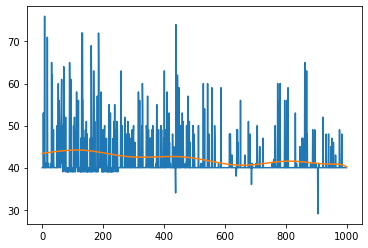

Episode : 500/1000000000, Score : 44, Exploration : 4%
Episode : 501/1000000000, Score : 36, Exploration : 4%
Episode : 502/1000000000, Score : 40, Exploration : 4%
Episode : 503/1000000000, Score : 40, Exploration : 4%
Episode : 504/1000000000, Score : 40, Exploration : 4%
Episode : 505/1000000000, Score : 40, Exploration : 4%
Episode : 506/1000000000, Score : 40, Exploration : 4%
Episode : 507/1000000000, Score : 50, Exploration : 4%
Episode : 508/1000000000, Score : 40, Exploration : 4%
Episode : 509/1000000000, Score : 40, Exploration : 4%
Episode : 510/1000000000, Score : 46, Exploration : 4%
Episode : 511/1000000000, Score : 40, Exploration : 4%
Episode : 512/1000000000, Score : 40, Exploration : 4%
Episode : 513/1000000000, Score : 40, Exploration : 4%
Episode : 514/1000000000, Score : 40, Exploration : 4%
Episode : 515/1000000000, Score : 40, Exploration : 4%
Episode : 516/1000000000, Score : 40, Exploration : 4%
Episode : 517/1000000000, Score : 40, Exploration : 4%
Episode : 

WebDriverException: Message: chrome not reachable
  (Session info: chrome=80.0.3987.106)


In [ ]:
# Entraînement
episodes = 1000000000

for e in range(episodes):

    # Initialisation de l'environnement (à chaque partie)
    restart()
    
    # On récupère l'image initiale (l'état initial dans lequel se trouve l'agent)
    frame = get_state()
    frames, stack_memory = stack(stack_memory, frame, new_episode = True)
    
    score = 0
    reward = 0

    # Début d'une partie
    while(True):

        # Choisir une action
        # Choisir une action : aléatoire ou prédite par le réseau de neurones
        # La part d'ations prédites augmente avec l'avancement de l'entraînement
        # Le but étant d'éviter que l'agent (le dino) ne se focalise sur une éventuelle solution sub-optimale
        if np.random.sample() < epsilon:
            # Action aléatoire
            action = random.sample(actions_space, 1)[0]
        else:
            # Action prédite par le CNN
            action = np.argmax(model.predict(frames))

        # Effectuer l'action
        do_action(action)
        
        # Récupérer le nouvel état, la récompense, savoir si le dino à heurter un obstacle
        new_frame = get_state()
        done = get_crashed()
        
        # On récupère le score de la partie en cours
        score = get_score()

        # Modélisation de la récompense attribuée à chaque action
        
        if get_crashed():
            # Si on obtient un "Game Over"
            reward = -100
        else:
            if action == 1:
                # Si le dino saute
                reward = -5
            else:
                # Si le dino décide de ne rien faire
                reward = 1
        
        # Mémoriser l'ancienne et la nouvelle observation puis la remplacer
        new_frames, stack_memory = stack(stack_memory, new_frame, new_episode = False)
        
        memory.append((frames, action, reward, done, new_frames))
        frames = new_frames
        
        if get_crashed():
            break

    scores.append(get_score())
    print('Episode : {}/{}, Score : {}, Exploration : {:.0%}'.format(e, episodes, score, epsilon))

    # Entraîner le réseau de neuronnes sur les expériences passées

    # Sélectionner des expériences aléatoirement dans la mémoire
    minibatch = random.sample(memory, batch_size)

    for frames, action, reward, done, new_frames in minibatch:
        
        '''
        Ancienne section liée à la structure "DQN"
        
        # Si "done" n'est pas atteint, on utilise l'équation de Bellman
        if not done:
            target = reward + discount_rate * np.amax(model.predict(new_frames))
        else:
            target = reward

        target_fit = model.predict(frames)
        target_fit[0][action] = target

        model.fit(frames, target_fit, epochs = 1, verbose = 0)
        '''
        
        # Si il n'y a pas de "Game Over", on utilise l'équation de Bellman
        # Cette section du code est développée dans le rapport
        
        target = model.predict(frames)
        target_next = model.predict(new_frames)
        target_val = target_model.predict(new_frames)
        
        if not done:
            a = np.argmax(target_next[0])
            target[0][action] = reward + discount_rate*target_val[0][a]
        else:
            target[0][action] = reward
        
        model.fit(frames, target, epochs=1, verbose=0)
        
    # On met à jour le deuxième réseau de neurones avec les poids du premiers   
    target_model.set_weights(model.get_weights())
    
    # On baisse le niveau d'exploration (part d'actions aléatoires) à chaque épisode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        
    # Toutes les 50 parties, on enregistre les poids du réseau de neurones, la mémoire et les scores (checkpoints)
    # Nous traçons également l'évolution des scores en fonction du nombre de parties
    if (e+1) % 50 == 0:
        
        model.save('D:/Desktop/Nouveau dossier/DinoAI.h5')
        print('---- Le modèle est sauvegardé ----')
        pickle.dump(memory, open('D:/Desktop/Nouveau dossier/memory.data', 'wb'))
        print('---- Le mémoire est sauvegardée ----')
        pickle.dump(scores, open('D:/Desktop/Nouveau dossier/scores.data', 'wb'))
        print('---- Les scores sont sauvegardés ----')
        
        X = range(len(scores))
        Y = scores
        reg = np.polyfit(X, Y, 10)
        reg_coeff = np.poly1d(reg)
        plt.plot(X, Y)
        plt.plot(X, reg_coeff(X))
        plt.show()